# Sphincs+ algorithm

In [1]:
from math import ceil, floor, log2
from copy import deepcopy
from hashlib import sha256
import hmac
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding

## Useful functions

In [2]:
def rot_left(n, d):
    return (n << d)|(n >> (32 - d)) & 0xFFFFFFFF

def rot_right(n, d):
    return (n >> d)|(n << (32 - d)) & 0xFFFFFFFF

A byte string can be considered as a string of base w numbers, i.e. integers in the set {0, . . . , w−
1}. The correspondence is defined by the function base_w(X, w, out_len) as follows. Let X be
a len_X- byte string, and w is an element of the set {4, 16, 256}, then base_w(X, w, out_len)
outputs an array of out_len integers between 0 and w − 1 (Figure 1). The length out_len is
REQUIRED to be less than or equal to 8 ∗ len_X/ log(w).

In [3]:
def base_w(X, w, out_len):
    i = 0
    total = 0
    bits = 0
    basew = []
    for consumed in range(out_len):
        if bits == 0:
            total = X[i]
            i += 1
            bits += 8
        bits -= int(log2(w))
        basew.append(rot_right(total, bits) & (w-1))
    return basew

base_w(b'\x12\x34', 16, 4)

[1, 2, 3, 4]

In [4]:
def xor(a, b):
    return bytearray([a[i] ^ b[i] for i in range(len(a))])

In [5]:
def num_to_bytes(num, length=8):
    return int.to_bytes(num, length=length, byteorder='big')

## Hash Functions

<font color='red'>TODO: Shorter Outputs. If a parameter set requires an output length n < 32-bytes for F, H, PRF,and PRFmsg we take the first n bytes of the output and discard the remaining.</font>


In [6]:
def MGF1(m, size, h=sha256):
    hlen = 32
    output = bytearray()
    for i in range(0, ceil(size/hlen)):
        ibytes = i.to_bytes(4, 'big')
        tmp = h(m + ibytes).digest()
        output = output + tmp
    return output[: size + 1]

In [7]:
def generate_mask(m, pk_seed, adrs, mask_len):
    m_arr = bytearray(m)
    mask = MGF1(pk_seed + adrs, mask_len)
    return xor(m_arr,mask)

In [8]:
import os
arr = bytearray([0, 0, 1, 0, 0, 0, 0, 0])
pk_seed = os.urandom(32)
mask_len = 32
test_m = ('t'*32).encode('utf-8')

generate_mask(test_m, pk_seed, arr, mask_len)

bytearray(b'wz\xdc\xba\x0e]\xfb\xce\xda\x0c\xe0R\xd4\xf26\x8d\x0e\x82\xce<\x9f|\xf7h\xf8.\n\xd8t\xd2\xc5H')

In [9]:
def F(pk_seed, adrs, m1):
    mask = generate_mask(m1, pk_seed, adrs, len(m1))
    mess = pk_seed + adrs + mask
    return sha256(mess).digest()

In [10]:
F(pk_seed, arr, test_m)

b'\x9b\xeaH\xcf0^\xda9\xc0\xafD`\xef\xf6\xb3\x9d\xab\xdfk\xf3X0\x91\xca\x1c\xe4^\xf5\xdf}\xd0\x96'

In [11]:
def H(pk_seed, adrs, m1, m2):
    mask1 = generate_mask(m1, pk_seed, adrs, len(m1))
    mask2 = generate_mask(m2, pk_seed, adrs, len(m2))
    mess = pk_seed + adrs + mask1 + mask2
    return sha256(mess).digest()

H(pk_seed, arr, test_m, test_m[:-1] + b'u')

b'\xd2\x89\x82\xd3\xed\xfcRqS\x93\xbe56\xf5E\x97;]\xd4C\x9bl\xa5e>\xa2\x95\xbb\xe0X\xc2\xcf'

In [12]:
def H_msg(r, pk_seed, pk_root, m):
    mess = r + pk_seed + pk_root + m
    sha = sha256(mess).digest()
    return MGF1(sha, len(m))

In [13]:
def PRF(seed, adrs):
    mess = seed + adrs
    return sha256(mess).digest()

In [14]:
def PRF_msg(sk_seed, sk_prf, opt_rand, m):
    hmac_value = hmac.new(sk_prf, opt_rand + m , sha256)
    return hmac_value.digest()

## WOTS+

Parameters:
* n - the security parameter - it is the message length as well as the length of a private key, public key, or signature element in bytes
* w - the Winternitz parameter; it is an element of the set {4, 16, 256}

These parameters are used to compute values _len_, _len1_ and _len2_:

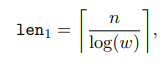

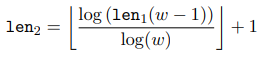



In [15]:
n = 32
w = 16
h = 64
len1 = ceil(n/log2(w))
len2 = floor(log2(len1*(w-1))/log2(w)) + 1
length = len1 + len2
print(len1, len2, length)

8 2 10


### Chaining Function

In [16]:
def chain(X, i, s, pk_seed, adrs):
    if s == 0:
        return X, adrs
    if i+s > w-1:
        return None, adrs
    tmp, adrs = chain(X, i, s-1, pk_seed, adrs)
    adrs[-8:] = num_to_bytes(i + s - 1) # hash address
    tmp = F(pk_seed, adrs, tmp)
    return tmp, adrs

### Private key generation

In [17]:
def wots_SKgen(sk_seed, adrs, length):
    sk = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain address
        sk += PRF(sk_seed, adrs)
    return sk, adrs

### Public key generation

In [18]:
def wots_PKgen(sk_seed, pk_seed, adrs):
    wotspkadrs = deepcopy(adrs)
    tmp = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain address
        sk = PRF(sk_seed, adrs)
        chain_res, adrs = chain(bytearray(sk[i]), 0, w-1, pk_seed, adrs)
        tmp += chain_res
    wotspkadrs[:8] = num_to_bytes(1) # set type to WOTS_PK
    wotspkadrs[8:16] = deepcopy(adrs[8:16]) # key pair
    pk = sha256(pk_seed + wotspkadrs + tmp).digest()
    return pk, adrs

### Signature Generation

In [19]:
def wots_sign(m, sk_seed, pk_seed, adrs, len1):
    csum = 0
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
    
    # convert csum to base w
    csum = rot_left(csum, (8 - ((len2 * int(log2(w)) % 8))))
    msg = msg + base_w(num_to_bytes(csum), w, len2)
    sig = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain
        sk = PRF(sk_seed, adrs)
        tmp, adrs = chain(sk, 0, msg[i], pk_seed, adrs)
        sig = sig + tmp
    return sig, adrs

### Compute Public Key from Signature

In [20]:
def wots_pk_from_sig(sig, m, pk_seed, adrs):
    csum = 0
    wotspkadrs = deepcopy(adrs)
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
        
    # convert csum to base w
    csum = rot_left(csum, ( 8 - ( ( len2 * int(log2(w)) ) % 8 )))
    msg += base_w(num_to_bytes(csum), w, len2)
    tmp = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain
        t, adrs = chain(bytearray(sig[i]), msg[i], w - 1 - msg[i], pk_seed, adrs);
        tmp += t
    wotspkadrs[:8] = num_to_bytes(1)
    wotspkadrs[8:16] = deepcopy(adrs[8:16])
    pk_sig = sha256(pk_seed + wotspkadrs + tmp).digest()
    return pk_sig, adrs


In [21]:
# generate keys
SK_SEED = bytearray(os.urandom(n))
PK_SEED = bytearray(os.urandom(n))
ADRS = bytearray(os.urandom(32))
M = bytearray(b"Ala ma kotka a kotek ma tez Ale!")
print(len(M))

wots_sk, adrs = wots_SKgen(SK_SEED, ADRS, length)
wots_pk, adrs = wots_PKgen(SK_SEED, PK_SEED, adrs)

# generate a signature
wots_sig, adrs = wots_sign(M, wots_sk, wots_pk, adrs, len1)

# compare public keys
wots_pk_from_sig(wots_sig, M, PK_SEED, adrs)[0]

32


b"\xeczS\xd1'\xab\x03\x9b\xcf\xae\x96\xc5O\xbb\xd8%N\xe5\x92\x87k3e\x9cY\x15\xfe\x1d\xeaI\xady"

In [22]:
wots_pk

b'\xfbaT\x03\xb4\x8f\xa4\xf4\xc0\xa8w\xa4\x81M\x1c\x92\xf6\x9f\x1a\x99!\xa6\xb8\xa4sa\xa0#"\x97\x9a\x02'